In [19]:
import pandas as pd

from sklearn.preprocessing import PolynomialFeatures as pf
from sklearn.preprocessing import LabelEncoder as le
from sklearn.preprocessing import KBinsDiscretizer as kb
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression as lr
from sklearn.linear_model import ElasticNetCV, Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import make_scorer
from sklearn.pipeline import make_pipeline, Pipeline

from scipy import stats

from scipy.interpolate import CubicSpline, UnivariateSpline

import seaborn as sns
import matplotlib.pyplot as plt

sns.set_context('notebook')
sns.set_style('whitegrid')

import numpy as np

from collections import Counter
import tabulate as tb

np.random.seed(42)

def plot_labels(t='', x='', y=''):
    plt.title(t)
    plt.xlabel(x)
    plt.ylabel(y)


In [2]:
test_d = pd.read_csv('./data/gss_test.csv')
train_d = pd.read_csv('./data/gss_train.csv')

assert set(test_d.columns) == set(train_d.columns)

maps = {}

for col in test_d.columns:
    d1, d2 = list(test_d[col]), list(train_d[col])
    encoder = le().fit(d1+d2)
    test_d[col] = encoder.transform(d1)
    train_d[col] = encoder.transform(d2)
    maps[col] = encoder.classes_

#print(f"Shapes\nTrain: {train_d.shape}\nTest: {test_d.shape}")
test_d, train_d = test_d.dropna(axis=0), train_d.dropna(axis=0)
#print(Counter(train_d.dtypes), Counter(test_d.dtypes))
#print(f"Shapes after dropping NaNs\nTrain: {train_d.shape}\nTest: {test_d.shape}")
      
x_tr, y_tr = train_d.drop('egalit_scale', axis=1), train_d['egalit_scale']
x_te, y_te = test_d.drop('egalit_scale', axis=1), test_d['egalit_scale']

x_tr, y_tr, x_te, y_te = [i.to_numpy() for i in [x_tr, y_tr, x_te, y_te]]
y_tr, y_te = (i.reshape(-1, 1) for i in (y_tr, y_te))

In [3]:
train_d.head()

,age,attend,authoritarianism,black,born,childs,colath,colrac,colcom,colmil,...,social_connect,social_cons3,south,spend3,teensex,tolerance,tvhours,vetyears,wordsum,zodiac
0,3,4,4,0,1,0,1,1,0,1,...,5,2,0,0,1,10,3,3,5,1
1,24,4,4,0,1,2,0,1,1,0,...,5,1,0,2,2,13,3,3,6,1
2,52,1,1,1,1,3,0,1,1,0,...,5,1,0,0,1,10,3,3,6,10
3,17,8,2,0,1,2,0,1,0,1,...,10,1,0,1,1,11,3,3,6,9
4,6,8,6,0,0,3,1,1,0,0,...,4,2,0,0,0,7,2,3,4,9


In [4]:
inc_tr, inc_te = (np.array(i).reshape(-1, 1) for i in (train_d['income06'], test_d['income06']))

## Q1. Polynomial regression

In [5]:
steps=[('poly', pf()), ('lr', lr())]
polyregression = Pipeline(steps)

parameters = {'poly__degree': range(1, 51)}
# sklearn is weird and MSE is actually negative
scorer = make_scorer(MSE, greater_is_better=False)
polycv = GridSearchCV(polyregression, parameters, scoring=scorer, cv=10)

polycv.fit(inc_tr, y_tr)

GridSearchCV(cv=10, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('poly',
                                        PolynomialFeatures(degree=2,
                                                           include_bias=True,
                                                           interaction_only=False,
                                                           order='C')),
                                       ('lr',
                                        LinearRegression(copy_X=True,
                                                         fit_intercept=True,
                                                         n_jobs=None,
                                                         normalize=False))],
                                verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'poly__degree': range(1, 51)}, pre_dispatch='2*n_jobs',
             refit=True, return_train_score=False,
    

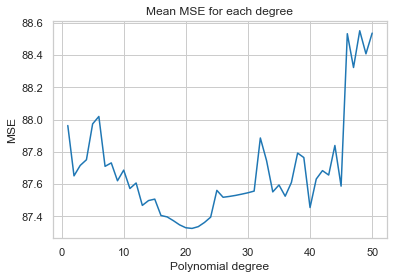

In [6]:
results = pd.DataFrame(polycv.cv_results_)
#print(results.head())
bestimator = polycv.best_estimator_
best_d = polycv.best_params_['poly__degree']

plt.plot(results.param_poly__degree, -1*results.mean_test_score)
plot_labels('Mean MSE for each degree', 'Polynomial degree', 'MSE')

The higher order polynomials clearly suffer from high training error - there is too much noise from the higher order terms. Instead, we find a minima at degree=21. 

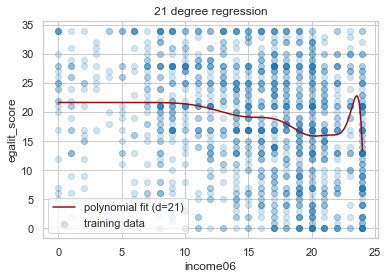

In [7]:
#print(bestimator)

inc_plot = np.linspace(inc_tr.min(), inc_tr.max(), 10000).reshape(-1, 1)
y_plot = bestimator.predict(inc_plot)

plt.scatter(inc_tr, y_tr, label='training data', alpha=0.2)
plt.plot(inc_plot, y_plot, label=f'polynomial fit (d={best_d})', c=plt.cm.Reds(0.9))
plt.legend()
plot_labels(f'{best_d} degree regression', 'income06', 'egalit_score')

AME =  -0.34958983056591825


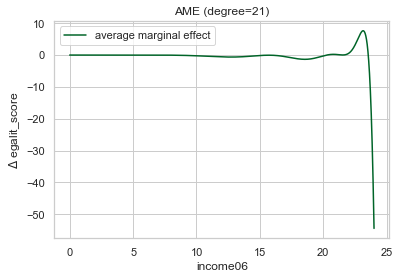

In [8]:
spacing = float(inc_plot[1]-inc_plot[0])
ame_plot = np.gradient(y_plot.reshape(-1), spacing)

plt.plot(inc_plot, ame_plot, label=f'average marginal effect', c=plt.cm.Greens(0.9))
plt.legend()
plot_labels(f'AME (degree={best_d})', 'income06', r'$\Delta$ egalit_score')

print("AME = ", ame_plot.mean())

The MSE varies as we vary the degree of polynomials. The mean cross-validated MSE is lowest at degree 21.

The average marginal effect is quite low for most of the range, and then spikes before becoming very negative at the end. This is largely anomalous, as the best fit polynomial is not indicative or reflective of any kind of trend. The computed AME is -0.35, indicating that there is a general negative trend in egalit_score as income increases. However, we can also identify from the plot that this is largely because of the sharply negative marginal effect at the end.

## Q2. Step regression

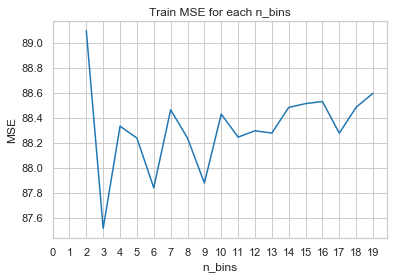

In [9]:
from sklearn.preprocessing import KBinsDiscretizer as kb
# method adapted from https://scikit-learn.org/stable/auto_examples/preprocessing/plot_discretization.html

step_predictor = Pipeline([('cut', kb()), ('lr', lr())])
parameters = {'cut__n_bins': range(1, 20)}

cv = GridSearchCV(step_predictor, parameters, n_jobs=-1, scoring='neg_mean_squared_error', cv=10)

cv.fit(inc_tr, y_tr)
bestimator = cv.best_estimator_
best_cuts = cv.best_params_['cut__n_bins']

results = pd.DataFrame(cv.cv_results_)
results.head()

plt.plot(results.param_cut__n_bins, -1*results.mean_test_score)
plot_labels('Train MSE for each n_bins', 'n_bins', 'MSE')
plt.xticks(range(20))
plt.show()

Test MSE = 87.74451576214251


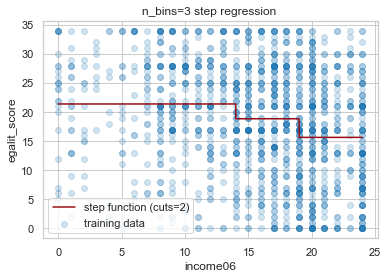

In [10]:
#print(bestimator)

inc_plot = np.linspace(inc_tr.min(), inc_tr.max(), 10000).reshape(-1, 1)
y_plot = bestimator.predict(inc_plot)

plt.scatter(inc_tr, y_tr, label='training data', alpha=0.2)
plt.plot(inc_plot, y_plot, label=f'step function (cuts={best_cuts-1})', c=plt.cm.Reds(0.9))
plt.legend()
plot_labels(f'n_bins={best_cuts} step regression ', 'income06', 'egalit_score')

print(f"Test MSE = {MSE(y_te, bestimator.predict(inc_te))}")

The fit is optimal when we split the data into 3 bins. As the data fluctuate wildly, and as we are constraining this to a step function, we expect a higher MSE than other methods (it is around 88). This is the cost of an extremely simplistic and parsimonious description of the data.

## Q3. Natural spline fit

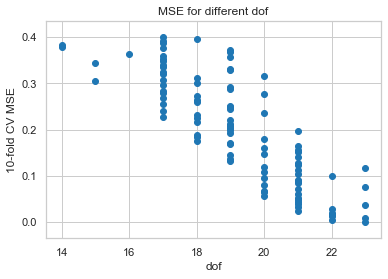

In [11]:
# https://scikit-learn.org/stable/auto_examples/preprocessing/plot_discretization.html

tenfold = KFold(n_splits=10)

log = {'mse':[], 'model':[], 'dof':[]}

s = iter(np.linspace(0, 10, 101))

exit = False

while not exit:
    for i_tr, i_te in tenfold.split(inc_tr, y_tr):
        df = pd.DataFrame({'x':list(inc_tr[i_tr].flatten()), 'y':list(y_tr[i_tr].flatten())})
        df.sort_values('x', inplace=True)
        df = df.groupby('x').mean()
        xtr1, ytr1 = np.array(df.index), np.array(df.y)
        sval = next(s, None)
        if sval is None:
            exit = True
            break
        sp = UnivariateSpline(xtr1, ytr1, k=3, s=sval)
        y_pred = sp(xtr1)
        mse = MSE(y_pred, ytr1)
        log['mse'].append(mse)
        log['model'].append(sp)
        log['dof'].append(len(sp.get_knots()))

best_ind = np.argmin(log['mse'])
bestimator = log['model'][best_ind]
best_mse = log['mse'][best_ind]

plt.scatter(log['dof'], log['mse'], label='dof')
plot_labels('MSE for different dof', 'dof', '10-fold CV MSE')

In sklearn, we control the number of knots with the smoothing parameter s. As shown in the graph, this optimally finds from 14 to 23 knots. As we cannot fit a spline to data has more than one Y value for the same X, we fit it to the mean Y for each X as shown below.

Test MSE = 89.3161758898812


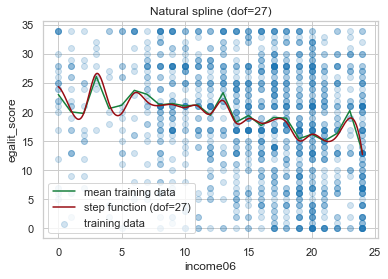

In [12]:
inc_plot = np.linspace(inc_tr.min(), inc_tr.max(), 10000).reshape(-1, 1)
y_plot = bestimator(inc_plot)

dof = 4+len(bestimator.get_knots())

plt.scatter(inc_tr, y_tr, label='training data', alpha=0.2)
plt.plot(xtr1, ytr1, label='mean training data', c=plt.cm.Greens(0.8))
plt.plot(inc_plot, y_plot, label=f'step function (dof={dof})', c=plt.cm.Reds(0.9))
plt.legend()
plot_labels(f'Natural spline (dof={dof})', 'income06', 'egalit_score')

print(f"Test MSE = {MSE(bestimator(inc_te), y_te)}")

In [13]:
print('Number of knots:\n', Counter([len(i.get_knots()) for i in log['model']]))

Number of knots:
 Counter({19: 21, 21: 20, 17: 19, 20: 13, 18: 12, 22: 6, 23: 5, 15: 2, 14: 2, 16: 1})


The best fit is for 23 knots (27 dof), which has a test MSE of 89. **This shows that the piecewise spline does not do much better than the relatively unintelligent step function. This is because the data are too widely spread out for any meaningful information to come out of regressions, piecewise or otherwise.**

# Egalitarianism and everything

## Q4. Four models

1. Linear regression

In [14]:
x1, x2 = StandardScaler(), StandardScaler()
x1, x2 = x1.fit(x_tr), x2.fit(x_te)
xtr_s, xte_s = x1.transform(x_tr), x2.transform(x_te)
print(x_tr.shape, y_tr.shape)
#print(x_te.shape, y_te.shape)

(1481, 44) (1481, 1)


In [15]:
lrcv = GridSearchCV(lr(), {}, scoring='neg_mean_squared_error', cv=10)

lrcv.fit(xtr_s, y_tr)

best_lr = lrcv.best_estimator_
lr_err = MSE(y_te, best_lr.predict(xte_s))
print(f"Linear regression test MSE for best model: {lr_err}")

Linear regression test MSE for best model: 63.928057088260516


In [16]:
elcv = ElasticNetCV(l1_ratio=[.1, .5, .7, .9, .95, .99, 1], n_alphas=10, cv=10)
y_tr = y_tr.reshape(-1,)
elcv.fit(xtr_s, y_tr)

el_err = MSE(y_te, elcv.predict(xte_s))
print(f"ElasticNet test MSE for best model: {el_err}\n\nParameters:\nlambda = {elcv.alpha_}\nalpha = {elcv.l1_ratio_}")

ElasticNet test MSE for best model: 62.56902435370069

Parameters:
lambda = 0.19753166246833653
alpha = 0.5


In [17]:
pcr = Pipeline([('pca', PCA()), ('ridge', Ridge())])
param_grid = {'pca__n_components':np.arange(2, 24, 2), 'ridge__alpha':[0.01, 0.05]+list(np.arange(0.1, 1, 10))}

pcacv = GridSearchCV(pcr, param_grid, scoring='neg_mean_squared_error', cv=10, refit=True)

pcacv.fit(xtr_s, y_tr)
best_pca = pcacv.best_estimator_
best_n = pcacv.best_params_['pca__n_components']
best_lambda = pcacv.best_params_['ridge__alpha']
pca_err = MSE(y_te, best_pca.predict(xte_s))

print(f"PCR test MSE for best model: {pca_err}\n\nParameters:\nn_components = {best_n}\nlambda = {best_lambda}")

PCR test MSE for best model: 62.74002057035896

Parameters:
n_components = 22
lambda = 0.1


In [18]:
pls = PLSRegression()

plscv = GridSearchCV(pls, param_grid={'n_components':np.arange(2, 21, 2)}, scoring='neg_mean_squared_error', cv=10)

plscv.fit(xtr_s, y_tr)
best_pls = plscv.best_estimator_
best_n = plscv.best_params_['n_components']
#best_lambda = plscv.best_params_['alpha']
pls_err = MSE(y_te, best_pls.predict(xte_s))

print(f"PCR test MSE for best model: {pls_err}\n\nParameters:\nn_components = {best_n}")#\nlambda = {best_lambda}")

PCR test MSE for best model: 63.927709350623815

Parameters:
n_components = 12


## Q5. Feature interaction plots

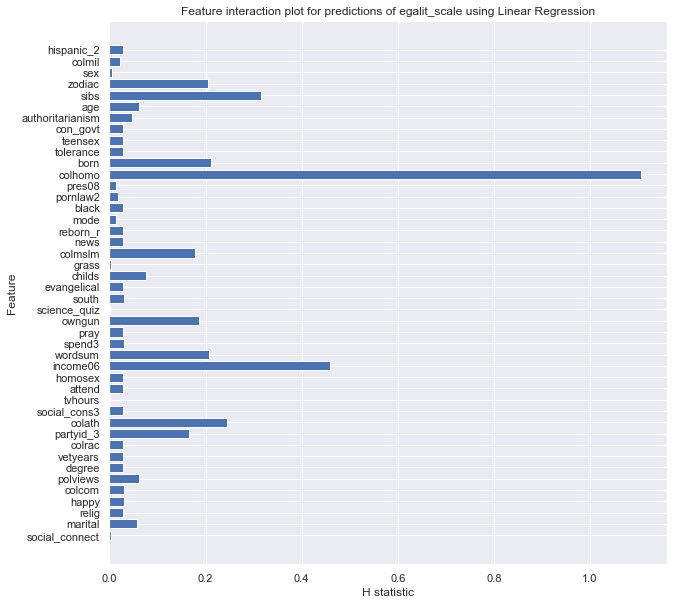

In [72]:
sns.set()

def feature_int_plot(model, df, f1, xte, yte, modelname):
    assert f1 in df.columns
    cols = set(df.columns)
    cols.remove(f1)
    fname, val = [], []
    for i, col in enumerate(cols):
        if f1 == col: continue
        fname.append(col)
        xnew = np.zeros(xte.shape)
        xnew[:, i] = xte[:, i]
        ynew = model.predict(xnew)
        ynew = ynew.reshape(yte.shape)
        val.append(stats.kruskal(ynew, yte)[0])
    plt.figure(figsize=(10, 10))
    plt.barh(np.arange(len(fname)), val)
    plt.yticks(np.arange(len(fname)), fname)
    plot_labels(f'Feature interaction plot for predictions of {f1} using {modelname}', 'H statistic', 'Feature')
        
feature_int_plot(best_lr, train_d, 'egalit_scale', xte_s, y_te, 'Linear Regression')

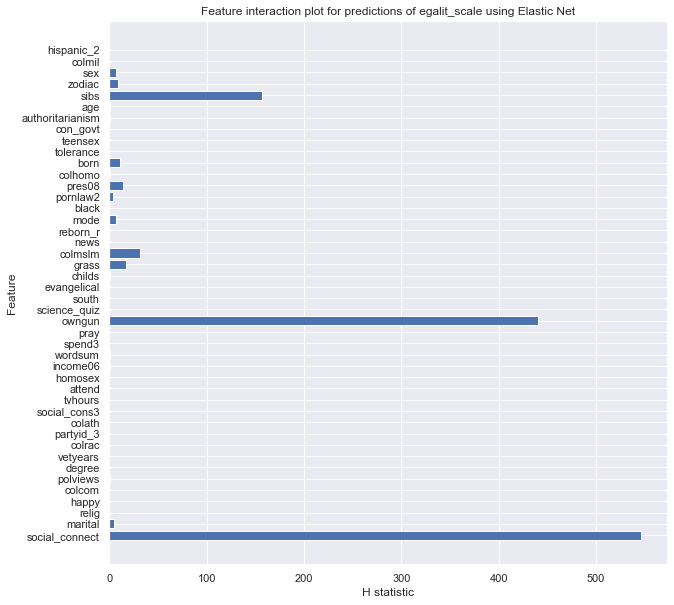

In [73]:
feature_int_plot(elcv, train_d, 'egalit_scale', x_te, y_te, 'Elastic Net')

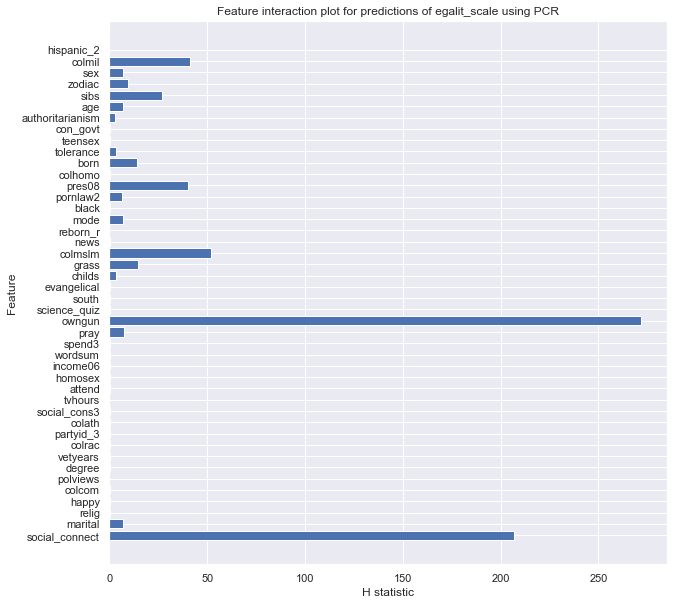

In [74]:
feature_int_plot(best_pca, train_d, 'egalit_scale', x_te, y_te, 'PCR')

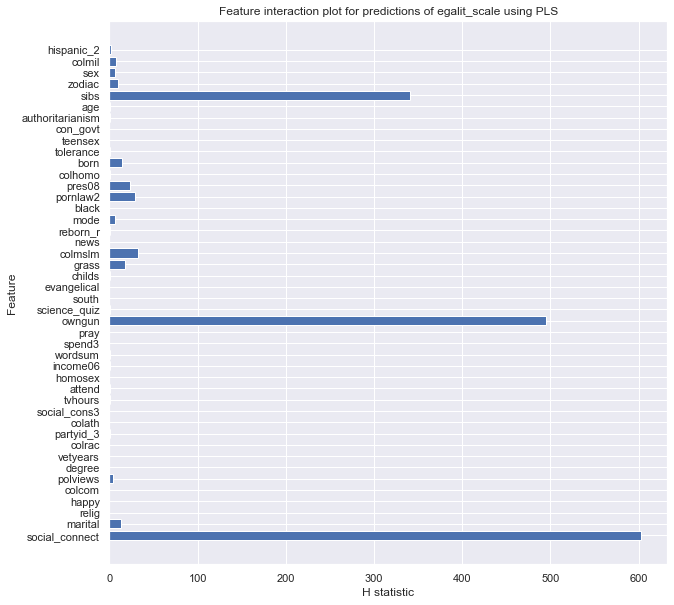

In [75]:
feature_int_plot(best_pls, train_d, 'egalit_scale', x_te, y_te, 'PLS')

The interaction plots represent interesting information about the correlations and dependencies of the features on each other.

For instance, there seems to be a strong indication that the `ownfun` variable interacts heavily with `egalit_scale` - this can be seen for the all models except the linear regression.

Interestingly, the simple regression displays the highest levels of mutual codependence, while the other three models seem to highly prioritize some variables rather than others in making their predictions. `social_connect` is another variable that we can see having conditional effects on the variable of interest. It displays a very high H statistic of over 300 for each of the models except linear regression.

This dominance of a few variables over others is indicative of a strong conditional dependence between them and the variable of interest. Such analysis can help us isolate causal factors and make inferential statements about the mechanisms at play.